In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint, Bounds
import scipy.special
from scipy.stats import binom
from tqdm import tqdm

In [106]:
# beta = 1
# B = 0
# kappa = 2
# The states are marked mu(x0, k), where x0 is the spin of the root node and k is the number of
# leaves that are spin-up

def eta(kappa=2):
    multiplicity = np.fromfunction(lambda _, k: scipy.special.comb(kappa, k), (2, kappa+1))
    eta = multiplicity / (2 ** (kappa+1))
    return eta

def Hamiltonian(x0, k, beta=1, B=0, kappa=2):
    x0 = 2 * x0 - 1
    return beta / 2 * x0 * (2 * k - kappa) + B * x0

def relative_entropy(p, q):
    p_divided_by_q = np.divide(p, q, out=np.ones_like(p), where=(p > 0) & (q > 0))
    partial = p * np.log(p_divided_by_q)
    return np.sum(partial)

def edge_distribution(p, kappa=2):
    counts = np.vstack((kappa - np.arange(kappa+1),
                        np.arange(kappa+1)))
    return p @ counts.T / kappa

def objective_function(mu, beta=1, B=0, kappa=2):
    hamiltonian = np.fromfunction(Hamiltonian, (2, kappa+1), beta=beta, B=B, kappa=kappa)
    exp = np.sum(hamiltonian * mu)
    rel_entr = relative_entropy(mu, eta(kappa=kappa))
    pi_mu = edge_distribution(mu)
    pi_eta = edge_distribution(eta(kappa=kappa))
    marg_rel_entr = relative_entropy(pi_mu, pi_eta)
    return exp - rel_entr + kappa / 2 * marg_rel_entr
    
def norm_constraint(mu):
    return np.sum(mu) - 1

# def norm_constraint_grad(mu):
#     return mu

def admissibility_constraint(mu):
    pi_mu = edge_distribution(mu)
    return pi_mu[0, 1] - pi_mu[1, 0]

# def admissibility_constraint_grad(mu):
#     grad_01 = np.concatenate([kappa - np.arange(kappa+1),
#                               np.zeros((1, kappa+1))], axis=0)
#     grad_10 = np.concatenate([np.zeros((1, kappa+1)),
#                               np.arange(kappa+1)], axis=0)
#     return grad_01 - grad_10

print(f'{eta()=}')
print(f'{edge_distribution(eta())=}')

eta()=array([[0.125, 0.25 , 0.125],
       [0.125, 0.25 , 0.125]])
edge_distribution(eta())=array([[0.25, 0.25],
       [0.25, 0.25]])


In [133]:
def optimize(beta, B, kappa, mu0=None, verbose=False, ftol=1e-9, constr_tol=1e-10):
    if mu0 is None:
        p_x0 = 1/2
        p_up = np.random.uniform(0, 1)
        p_xv0 = binom.pmf(np.arange(kappa+1), kappa, p_up)
        p_xv1 = binom.pmf(np.arange(kappa+1), kappa, 1 - p_up)
        mu0 = np.vstack([p_xv0, p_xv1]) * np.array([[p_x0], [1 - p_x0]])
    
    if verbose:
        print(f'{beta=}, {B=}, {kappa=}\n{mu0=}')
    
    bounds = Bounds(np.zeros_like(mu0.flatten()), np.ones_like(mu0.flatten()), keep_feasible=True)

    norm_constraint = LinearConstraint(np.ones_like(mu0.flatten()), 1, 1, keep_feasible=True)
    admissibility_linear = np.hstack((-np.arange(kappa+1), kappa - np.arange(kappa+1))) / kappa
    admissibility_constraint = LinearConstraint(admissibility_linear, lb=0, ub=0, keep_feasible=True)
    
    res = minimize(lambda mu: -objective_function(mu.reshape(2, kappa+1), beta=beta, B=B, kappa=kappa),
                   x0=mu0.flatten(), method='SLSQP', 
                   constraints=[norm_constraint, admissibility_constraint],
                   bounds=bounds,
                   options={'ftol': ftol, 'disp': verbose})
    
    mu = res.x.reshape(2, kappa+1)
    
    if verbose:
        print(f'{objective_function(mu)=}\n')
        print(f'{mu=}\n\n{np.sum(mu)=}\n\n{edge_distribution(mu)=}')
    
    return mu

In [134]:
mu = optimize(beta=1, B=0, kappa=2, verbose=True)

beta=1, B=0, kappa=2
mu0=array([[0.04286413, 0.20706563, 0.25007024],
       [0.25007024, 0.20706563, 0.04286413]])
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.433780830385878
            Iterations: 18
            Function evaluations: 134
            Gradient evaluations: 18
objective_function(mu)=0.433780830385878

mu=array([[0.38790917, 0.10499272, 0.0071041 ],
       [0.00710368, 0.10499356, 0.38789676]])

np.sum(mu)=1.0

edge_distribution(mu)=array([[0.44040554, 0.05960046],
       [0.05960046, 0.44039354]])


/Users/yizhonghu/anaconda3/lib/python3.8/site-packages/scipy/optimize/_constraints.py:353: OptimizeWarning: Constraint option `keep_feasible` is ignored by this method.
  warn("Constraint option `keep_feasible` is ignored by this "


### P(X0, X1)

In [143]:
mu = optimize(beta=-10, B=0, kappa=2, ftol=1e-10)

pi_mu = edge_distribution(mu)
print(f'{pi_mu=}')
p_x0 = np.sum(pi_mu, axis=1)
p_x1 = np.sum(pi_mu, axis=0)
print(f'{p_x0=}', f'{p_x1=}')
print(f'{np.outer(p_x0, p_x1)=}')

pi_mu=array([[1.50657264e-13, 5.00000000e-01],
       [5.00000000e-01, 1.19113053e-13]])
p_x0=array([0.5, 0.5]) p_x1=array([0.5, 0.5])
np.outer(p_x0, p_x1)=array([[0.25, 0.25],
       [0.25, 0.25]])


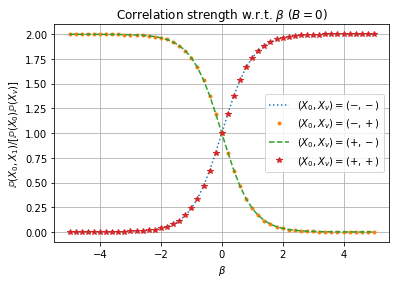

In [155]:
betas = np.linspace(-5, 5, 51)
probabilities = []

for beta in betas:
    mu = optimize(beta=beta, B=0, kappa=2, ftol=1e-10)
    pi_mu = edge_distribution(mu)
    p_x0 = np.sum(pi_mu, axis=1)
    p_x1 = np.sum(pi_mu, axis=0)
    indep_dist = np.outer(p_x0, p_x1)
    probabilities.append(pi_mu / indep_dist)
    
probabilities = np.array(probabilities)

plt.plot(betas, probabilities[:, 0, 0], ':', label='$(X_0, X_v)=(-, -)$')
plt.plot(betas, probabilities[:, 0, 1], '.', label='$(X_0, X_v)=(-, +)$')
plt.plot(betas, probabilities[:, 1, 0], '--', label='$(X_0, X_v)=(+, -)$')
plt.plot(betas, probabilities[:, 1, 1], '*', label='$(X_0, X_v)=(+, +)$')
plt.legend()
plt.title('Correlation strength w.r.t. $\\beta$ ($B=0$)')
plt.xlabel('$\\beta$')
plt.ylabel('$\\mathbb{P}(X_0, X_1) / [\\mathbb{P}(X_0)\\mathbb{P}(X_v)]$')
plt.grid(True)
plt.savefig('../img/ising_x0_xv.png')

/Users/yizhonghu/anaconda3/lib/python3.8/site-packages/scipy/optimize/_constraints.py:353: OptimizeWarning: Constraint option `keep_feasible` is ignored by this method.
  warn("Constraint option `keep_feasible` is ignored by this "


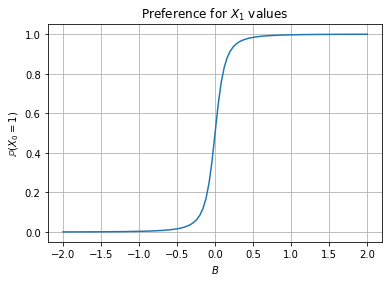

In [167]:
Bs = np.linspace(-2, 2, 101)
probabilities = []

for B in Bs:
    mu = optimize(beta=1, B=B, kappa=2, ftol=1e-10)
    probabilities.append(np.sum(mu[1]))
    
plt.plot(Bs, probabilities)
plt.title('Preference for $X_1$ values')
plt.xlabel('$B$')
plt.ylabel('$\mathbb{P}(X_0=1)$')
plt.grid(True)
plt.savefig('../img/ising_x0_B.png')

### P(X1, X2)

In [160]:
mu_edge = np.sum(mu, axis=0)
leaf_dist = np.array([[mu_edge[2], mu_edge[1] / 2],
                      [mu_edge[1] / 2, mu_edge[0]],])
print(f'{leaf_dist=}')
p_x1 = np.sum(leaf_dist, axis=1)
p_x2 = np.sum(leaf_dist, axis=0)
print(f'{p_x1=}', f'{p_x2=}')
print(f'{np.outer(p_x1, p_x2)=}')

leaf_dist=array([[4.99954616e-01, 4.53837494e-05],
       [4.53837494e-05, 4.99954616e-01]])
p_x1=array([0.5, 0.5]) p_x2=array([0.5, 0.5])
np.outer(p_x1, p_x2)=array([[0.25, 0.25],
       [0.25, 0.25]])


### P(X1, X2 | X0)

In [162]:
x0 = 1
mu_edge = mu[x0] / np.sum(mu, axis=1)[x0]
print(f'{mu_edge=}')
leaf_dist = np.array([[mu_edge[2], mu_edge[1] / 2],
                      [mu_edge[1] / 2, mu_edge[0]],])
print(f'{leaf_dist=}')
p_x1 = np.sum(leaf_dist, axis=1)
p_x2 = np.sum(leaf_dist, axis=0)
print(f'{p_x1=}', f'{p_x2=}')
print(f'{np.outer(p_x1, p_x2)=}')

mu_edge=array([1.02431541e-14, 9.07674988e-05, 9.99909233e-01])
leaf_dist=array([[9.99909233e-01, 4.53837494e-05],
       [4.53837494e-05, 1.02431541e-14]])
p_x1=array([9.99954616e-01, 4.53837494e-05]) p_x2=array([9.99954616e-01, 4.53837494e-05])
np.outer(p_x1, p_x2)=array([[9.99909235e-01, 4.53816897e-05],
       [4.53816897e-05, 2.05968471e-09]])
